In [396]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import itertools
import matplotlib.pyplot as plt
from sklearn.base import clone
import xgboost as xgb
from catboost import CatBoostRegressor

In [421]:
class RegressionTimeSeriesForecaster:
    def __init__(self, model):
        self.model = model
    
    def prepare_data(self, data, categorical_col_name, targets, steps_ahead, scaler = None):
        self.categorical_col_name = categorical_col_name
        self.targets = []
        # Need to copy, otherwise weirdly is working on the parameters passed directly
        data = data.copy()
        data["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in data.iterrows()]
        data["Date"] = pd.to_datetime(data["Date"])
        data.index = data["Date"]
        data.drop(columns=["Date"], inplace=True)
        data[categorical_col_name] = data[categorical_col_name].astype("category")
        
        for target in targets:
            for i in range(1, steps_ahead+1):
                data[f"{target}_+{i}"] = data.groupby(categorical_col_name)[target].shift(-i)
                self.targets.append(f"{target}_+{i}")


        data = data.dropna()
        
        # Possibly code for standarization in deep learning part
        # columns_to_scale = data.drop(columns=[self.categorical_col_name, "year", "month"]).columns.values
        # self.data_mean = data[columns_to_scale].mean()
        # self.data_std = data[columns_to_scale].std()

        # data[columns_to_scale] = (data[columns_to_scale] - self.data_mean)/self.data_std

        self.data = data

        return self
    
    def split_category_data(self, n_splits):
        data_dict = {f"iter_{i}": {"train": pd.DataFrame(), "test": pd.DataFrame()} for i in range(1, n_splits+1)}

        # Tworzenie TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=n_splits)

        for category in data[self.categorical_col_name].unique():
            for i, (train_index, test_index) in enumerate(tscv.split(self.data[self.data[self.categorical_col_name] == category].index.values)):
                train_data = self.data[self.data[self.categorical_col_name] == category].iloc[train_index]
                test_data = self.data[self.data[self.categorical_col_name] == category].iloc[test_index]

                data_dict[f"iter_{i+1}"]["train"] = data_dict[f"iter_{i+1}"]["train"].append(train_data, ignore_index=True)
                data_dict[f"iter_{i+1}"]["test"] = data_dict[f"iter_{i+1}"]["test"].append(test_data, ignore_index=True)
        
        return data_dict

    def get_data(self):
        pass

    def random_search(self, param_grid, num_samples):
        random_combinations = []

        while len(random_combinations) < num_samples:
            random_combination = {}
            for param, values in param_grid.items():
                random_value = random.choice(values)
                random_combination[param] = random_value

            if random_combination not in random_combinations:
                random_combinations.append(random_combination)

        return random_combinations

    def grid_search(self, param_grid):
        # Generate all combinations of parameters
        grid_combinations = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
        return grid_combinations

    def optimize_model(self, params, cv_splits = 5, search_method = "random", num_samples = 60):
        list_rmse = []
        if search_method == "random":
            all_params = self.random_search(params, num_samples)
            # Use cross validation to evaluate all parameters
            self.data_dict = self.split_category_data(cv_splits)
            for i, params in enumerate(all_params):
                model = clone(self.model)
                model.set_params(**params, n_jobs=-1)
                print(f"Searching: {i+1}/{len(all_params)}")
                print(model.get_params())
                temp_rmse = []
                for i in range(1, cv_splits+1):
                    train, test = self.data_dict[f"iter_{i}"]["train"], self.data_dict[f"iter_{i}"]["test"]
            
                    # One-hot encoding  
                    train_dummies = pd.get_dummies(train, columns=[self.categorical_col_name])
                    test_dummies = pd.get_dummies(test, columns=[self.categorical_col_name])

                    Xtr = train_dummies.drop(columns=list(train_dummies.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1).columns))
                    ytr = train_dummies.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1)

                    Xtest = test_dummies.drop(columns=list(test_dummies.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1).columns))
                    ytest = test_dummies.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1)

                    model.fit(Xtr, ytr)

                    preds = model.predict(Xtest)

                    scores = {"rmse": sqrt(mse(ytest, preds)), "wmape": wmape(ytest, preds), "r2": r2_score(ytest, preds)}

                    print(f"iter_{i}: rmse: {scores['rmse']}")
                    
                    temp_rmse.append(scores["rmse"])
                list_rmse.append(temp_rmse)
        elif search_method == "grid":
            all_params = self.grid_search(params)
            # Use cross validation to evaluate all parameters
            self.data_dict = self.split_category_data(cv_splits)
            for i, params in enumerate(all_params):
                model = clone(self.model)
                model.set_params(**params, n_jobs=-1)
                print(f"Searching: {i+1}/{len(all_params)}")
                print(model.get_params())
                temp_rmse = []
                for i in range(1, cv_splits+1):
                    train, test = self.data_dict[f"iter_{i}"]["train"], self.data_dict[f"iter_{i}"]["test"]
            
                    # One-hot encoding  
                    train_dummies = pd.get_dummies(train, columns=[self.categorical_col_name])
                    test_dummies = pd.get_dummies(test, columns=[self.categorical_col_name])

                    Xtr = train_dummies.drop(columns=list(train_dummies.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1).columns))
                    ytr = train_dummies.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1)

                    Xtest = test_dummies.drop(columns=list(test_dummies.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1).columns))
                    ytest = test_dummies.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1)

                    model.fit(Xtr, ytr)

                    preds = model.predict(Xtest)

                    scores = {"rmse": sqrt(mse(ytest, preds)), "wmape": wmape(ytest, preds), "r2": r2_score(ytest, preds)}

                    print(f"iter_{i}: rmse: {scores['rmse']}")
                    
                    temp_rmse.append(scores["rmse"])
                list_rmse.append(temp_rmse)

        # Tuning results
        tuning_results = pd.DataFrame(all_params)
        tuning_results['rmse_mean'] = [j[0] for j in [[np.mean(i), np.std(i)] for i in list_rmse]]
        tuning_results['rmse_std'] = [j[1] for j in [[np.mean(i), np.std(i)] for i in list_rmse]]

        best_params = all_params[np.argmin([j[0] for j in [[np.mean(i), np.std(i)] for i in list_rmse]])]
        return tuning_results, best_params

    def train_model(self):
        pass

    def save_model(self):
        pass

    def get_scores(self, tbl_preds):
        tbl_scores = {"Iter_n": [], "FarmID": [], "Target": [], "rmse": [], "wmape": [], "r2": []}
        for i in tbl_preds["Iter_n"].unique():
            for farmid in tbl_preds[self.categorical_col_name].unique():
                for target in self.targets:
                    farmid_indexes = tbl_preds[tbl_preds["Iter_n"] == i].index[tbl_preds[tbl_preds["Iter_n"] == i][self.categorical_col_name] == farmid].tolist()
                    real = tbl_preds[tbl_preds["Iter_n"] == i].iloc[farmid_indexes, :][target]
                    preds = tbl_preds[tbl_preds["Iter_n"] == i].iloc[farmid_indexes, :][f"{target}_pred"]
                    tbl_scores["Iter_n"].append(i)
                    tbl_scores["FarmID"].append(farmid)
                    tbl_scores["Target"].append(target)
                    tbl_scores["rmse"].append(sqrt(mse(real, preds)))
                    tbl_scores["wmape"].append(wmape(real, preds))
                    tbl_scores["r2"].append(r2_score(real, preds))

        return pd.DataFrame(tbl_scores)

    def evaluate_model(self, cv_splits=5):
        self.data_dict = self.split_category_data(cv_splits)

        tbl_preds = pd.DataFrame()
        for i in range(1, cv_splits+1):
            train, test = self.data_dict[f"iter_{i}"]["train"], self.data_dict[f"iter_{i}"]["test"]
            
            # One-hot encoding  
            train_dummies = pd.get_dummies(train, columns=[self.categorical_col_name])
            test_dummies = pd.get_dummies(test, columns=[self.categorical_col_name])

            Xtr = train_dummies.drop(columns=list(train_dummies.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1).columns))
            ytr = train_dummies.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1)

            Xtest = test_dummies.drop(columns=list(test_dummies.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1).columns))
            ytest = test_dummies.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1)

            self.model.fit(Xtr, ytr)

            preds = self.model.predict(Xtest)

            # Possibly code for standarization in deep learning part
            # preds = pd.DataFrame(preds)

            # if self.data_mean.any() and self.data_std.any():
            #     for target in self.targets:
            #         ytest[target] = ytest[target] * self.data_std[target] + self.data_mean[target]
            #         preds[self.targets.index(target)] = preds[self.targets.index(target)] * self.data_std[target] + self.data_mean[target]

            temp_outcome = test[["FarmID", "year", "month"] + self.targets].copy()
            temp_outcome["Iter_n"] = i
            for target in self.targets:
                temp_outcome[f"{target}_pred"] = preds[:, self.targets.index(target)]
            tbl_preds = tbl_preds.append(temp_outcome)

        tbl_scores = self.get_scores(tbl_preds)
                    
        return self.model, tbl_preds, tbl_scores



In [419]:
preds[preds["Iter_n"] == 1]

,FarmID,year,month,Tiny+Small_+1,Tiny+Small_+2,Tiny+Small_+3,Tiny+Small_+4,Tiny+Small_+5,Tiny+Small_+6,Large+Mature_+1,...,Tiny+Small_+3_pred,Tiny+Small_+4_pred,Tiny+Small_+5_pred,Tiny+Small_+6_pred,Large+Mature_+1_pred,Large+Mature_+2_pred,Large+Mature_+3_pred,Large+Mature_+4_pred,Large+Mature_+5_pred,Large+Mature_+6_pred
0,AG10,2002,4,26.00,106.00,143.00,143.00,134.30,125.60,18.00,...,104.34,97.28,66.37,40.22,18.17,18.18,27.47,64.59,94.91,84.55
1,AG10,2002,5,106.00,143.00,143.00,134.30,125.60,116.90,14.00,...,90.87,54.22,29.05,23.20,18.57,27.76,57.47,99.05,88.46,60.41
2,AG10,2002,6,143.00,143.00,134.30,125.60,116.90,108.20,50.00,...,30.74,18.74,18.47,17.05,48.92,67.15,63.79,43.40,29.46,18.60
3,AG10,2002,7,143.00,134.30,125.60,116.90,108.20,99.50,116.00,...,26.08,24.52,29.54,22.67,78.95,105.52,80.63,48.87,29.05,21.43
4,AG10,2002,8,134.30,125.60,116.90,108.20,99.50,90.80,107.70,...,21.27,25.15,30.14,27.84,129.90,96.35,60.21,30.59,16.77,23.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,MA413,2019,9,21.00,24.00,51.00,42.00,46.00,26.00,36.00,...,52.97,40.34,27.55,26.23,40.72,32.03,29.21,41.50,42.69,41.37
1402,MA413,2019,10,24.00,51.00,42.00,46.00,26.00,15.50,25.00,...,39.46,31.59,31.84,27.64,30.72,29.02,30.62,38.69,39.95,34.62
1403,MA413,2019,11,51.00,42.00,46.00,26.00,15.50,5.00,28.00,...,38.18,30.66,26.51,31.12,26.20,31.53,38.46,42.48,40.09,33.37
1404,MA413,2019,12,42.00,46.00,26.00,15.50,5.00,14.00,33.00,...,33.60,39.20,63.02,63.49,30.35,38.72,44.09,29.12,21.82,27.28


In [441]:
randomForestTimeSeriesForecaster = RegressionTimeSeriesForecaster(RandomForestRegressor())
forest_model, forest_preds, forest_scores = randomForestTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6).evaluate_model()

In [443]:
print(forest_scores.groupby("Iter_n").mean()["rmse"])
print(forest_scores.mean()["rmse"])
print(forest_scores[forest_scores["rmse"] == forest_scores["rmse"].min()])

Iter_n
1   27.05
2   26.47
3   24.04
4   24.26
5   24.07
Name: rmse, dtype: float64
25.177338516829867
      Iter_n FarmID           Target  rmse  wmape   r2
1327       2  GA331  Large+Mature_+2  2.78   0.15 0.90


In [445]:
forest_scores.groupby("Target").mean()["rmse"]

Target
Large+Mature_+1   15.56
Large+Mature_+2   17.58
Large+Mature_+3   20.93
Large+Mature_+4   24.12
Large+Mature_+5   25.06
Large+Mature_+6   25.07
Tiny+Small_+1     23.03
Tiny+Small_+2     29.28
Tiny+Small_+3     30.50
Tiny+Small_+4     30.16
Tiny+Small_+5     30.31
Tiny+Small_+6     30.52
Name: rmse, dtype: float64

In [422]:
params = {'learning_rate': 0.3, 
          'depth': 6, 
          'l2_leaf_reg': 3, 
          'loss_function': 'MultiRMSE', 
          'eval_metric': 'MultiRMSE', 
          'task_type': 'CPU', 
          'iterations': 150,
          'od_type': 'Iter', 
          'boosting_type': 'Plain', 
          'bootstrap_type': 'Bernoulli', 
          'allow_const_label': True, 
         }
catBoostTimeSeriesForecaster = RegressionTimeSeriesForecaster(CatBoostRegressor(**params))
cat_model, cat_preds, cat_scores = catBoostTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6).evaluate_model()

0:	learn: 129.1423503	total: 30.3ms	remaining: 4.51s
1:	learn: 123.4711025	total: 60.8ms	remaining: 4.5s
2:	learn: 119.2567215	total: 92.5ms	remaining: 4.53s
3:	learn: 114.7517808	total: 123ms	remaining: 4.48s
4:	learn: 111.9490530	total: 162ms	remaining: 4.68s
5:	learn: 109.2541272	total: 200ms	remaining: 4.81s
6:	learn: 107.2553415	total: 245ms	remaining: 5.01s
7:	learn: 106.0004303	total: 286ms	remaining: 5.08s
8:	learn: 104.7744388	total: 333ms	remaining: 5.21s
9:	learn: 103.0311573	total: 377ms	remaining: 5.28s
10:	learn: 101.6226910	total: 424ms	remaining: 5.35s
11:	learn: 100.3731595	total: 469ms	remaining: 5.39s
12:	learn: 99.4317067	total: 516ms	remaining: 5.43s
13:	learn: 98.4639828	total: 566ms	remaining: 5.5s
14:	learn: 97.6879910	total: 612ms	remaining: 5.5s
15:	learn: 96.8509441	total: 654ms	remaining: 5.48s
16:	learn: 96.0726834	total: 698ms	remaining: 5.46s
17:	learn: 95.2645316	total: 741ms	remaining: 5.43s
18:	learn: 94.4323571	total: 787ms	remaining: 5.43s
19:	learn:

In [461]:
print(cat_scores.groupby("Iter_n").mean()["rmse"])
print(cat_scores.mean()["rmse"])
print(cat_scores[cat_scores["wmape"] == cat_scores["wmape"].min()])
print(xgb_scores[cat_scores["r2"] == cat_scores["r2"].max()])

Iter_n
1   26.07
2   26.03
3   22.94
4   23.84
5   22.97
Name: rmse, dtype: float64
24.37009931306009
      Iter_n FarmID           Target  rmse  wmape   r2
1278       2  SP317  Large+Mature_+1  9.62   0.14 0.75
      Iter_n FarmID           Target  rmse  wmape   r2
1362       2  GA302  Large+Mature_+1  8.28   0.35 0.79


In [460]:
cat_scores.groupby("Target").mean()

,Iter_n,rmse,wmape,r2
Target,,,,
Large+Mature_+1,3.00,14.72,0.33,0.41
Large+Mature_+2,3.00,17.11,0.40,0.15
Large+Mature_+3,3.00,20.43,0.49,-0.23
Large+Mature_+4,3.00,23.20,0.58,-0.62
Large+Mature_+5,3.00,23.97,0.62,-0.77
Large+Mature_+6,3.00,24.15,0.65,-0.94
Tiny+Small_+1,3.00,22.81,0.52,-0.00
Tiny+Small_+2,3.00,28.38,0.69,-0.91
Tiny+Small_+3,3.00,29.60,0.74,-1.03


In [436]:
xgBoostTimeSeriesForecaster = RegressionTimeSeriesForecaster(xgb.XGBRegressor())
xgb_model, xgb_preds, xgb_scores = xgBoostTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6).evaluate_model()

In [456]:
print(xgb_scores.groupby("Iter_n").mean()["rmse"])
print(xgb_scores.mean()["rmse"])
print(xgb_scores[xgb_scores["rmse"] == xgb_scores["rmse"].min()])
print(xgb_scores[xgb_scores["r2"] == xgb_scores["r2"].max()])

Iter_n
1   27.18
2   27.20
3   24.40
4   24.98
5   24.59
Name: rmse, dtype: float64
25.668893367277473
     Iter_n FarmID           Target  rmse  wmape   r2
666       1  SP310  Large+Mature_+1  3.12   0.25 0.87
      Iter_n FarmID           Target  rmse  wmape   r2
3727       5  SP317  Large+Mature_+2 12.11   0.23 0.92


In [447]:
xgb_scores.groupby("Target").mean()["rmse"]

Target
Large+Mature_+1   15.05
Large+Mature_+2   17.88
Large+Mature_+3   21.43
Large+Mature_+4   24.71
Large+Mature_+5   25.23
Large+Mature_+6   24.69
Tiny+Small_+1     24.64
Tiny+Small_+2     30.21
Tiny+Small_+3     32.14
Tiny+Small_+4     30.47
Tiny+Small_+5     30.37
Tiny+Small_+6     31.20
Name: rmse, dtype: float64

In [448]:
cat_preds["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in cat_preds.iterrows()]
cat_preds["Date"] = pd.to_datetime(cat_preds["Date"])
cat_preds.index = cat_preds["Date"]
cat_preds.drop(columns=["Date"], inplace=True)

<Axes: xlabel='Date'>

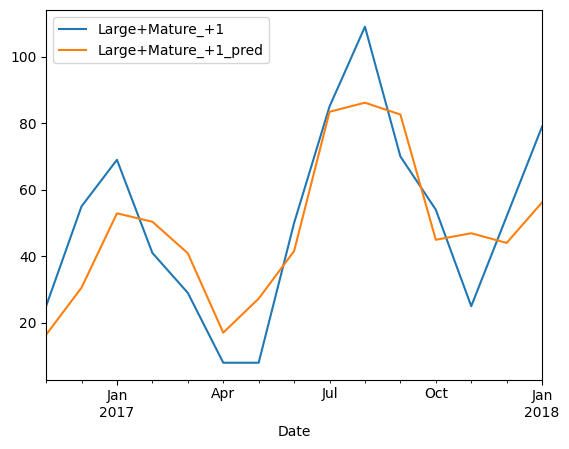

In [462]:
cat_preds[(cat_preds["Iter_n"] == 1) & (cat_preds["FarmID"] == "SP317")][["Large+Mature_+1", "Large+Mature_+1_pred"]].plot()

In [477]:
cat_preds_temp = cat_preds.groupby(["year", "month"]).mean().reset_index()
cat_preds_temp["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in cat_preds_temp.iterrows()]
cat_preds_temp["Date"] = pd.to_datetime(cat_preds_temp["Date"])
cat_preds_temp.index = cat_preds_temp["Date"]
cat_preds_temp.drop(columns=["Date"], inplace=True)

<Axes: xlabel='Date'>

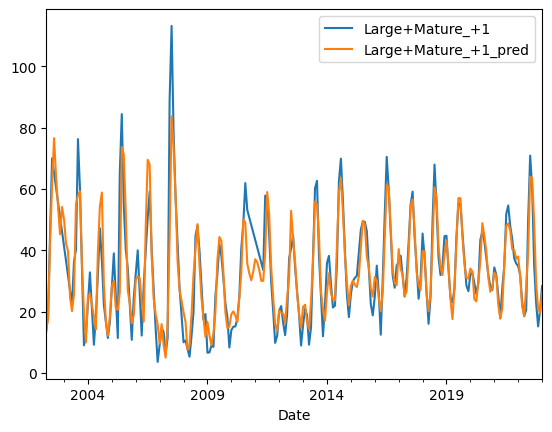

In [482]:
cat_preds_temp[["Large+Mature_+1", "Large+Mature_+1_pred"]].plot()

In [458]:
xgb_preds["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in xgb_preds.iterrows()]
xgb_preds["Date"] = pd.to_datetime(xgb_preds["Date"])
xgb_preds.index = xgb_preds["Date"]
xgb_preds.drop(columns=["Date"], inplace=True)

<Axes: xlabel='Date'>

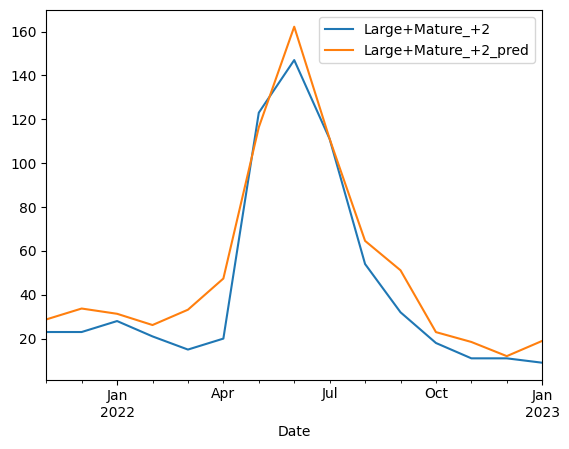

In [459]:
xgb_preds[(xgb_preds["Iter_n"] == 5) & (xgb_preds["FarmID"] == "SP317")][["Large+Mature_+2", "Large+Mature_+2_pred"]].plot()

In [370]:
# Set up parameter grid
param_grid = {  
    'bootstrap': [True, False],
    'max_depth': [None] + [i for i in range(10, 1010, 10)],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [5],
    'n_estimators': [200, 400]
}

In [391]:
results, best_params = RegressionTimeSeriesForecaster(RandomForestRegressor()).prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6).optimize_model(param_grid, cv_splits = 5, search_method = "random", num_samples = 2)

Searching: 1/2
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 90, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
iter_1: rmse: 34.75141544880001
iter_2: rmse: 36.460691378720306
iter_3: rmse: 29.238122205800508
iter_4: rmse: 29.356211103142382
iter_5: rmse: 26.8618723220286
Searching: 2/2
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 970, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
iter_1: rmse: 35.05749771779045
iter_2: rmse: 36.887445

In [287]:
preds["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in preds.iterrows()]
preds["Date"] = pd.to_datetime(preds["Date"])
preds.index = preds["Date"]
preds.drop(columns=["Date"], inplace=True)

In [343]:
preds[preds["Iter_n"] == 1]

,FarmID,year,month,Tiny+Small_+1,Tiny+Small_+2,Tiny+Small_+3,Tiny+Small_+4,Tiny+Small_+5,Tiny+Small_+6,Large+Mature_+1,...,Tiny+Small_+3_pred,Tiny+Small_+4_pred,Tiny+Small_+5_pred,Tiny+Small_+6_pred,Large+Mature_+1_pred,Large+Mature_+2_pred,Large+Mature_+3_pred,Large+Mature_+4_pred,Large+Mature_+5_pred,Large+Mature_+6_pred
0,AG10,2002,4,26.00,106.00,143.00,143.00,134.30,125.60,18.00,...,91.19,82.50,56.80,37.95,18.19,18.42,28.66,62.53,91.85,76.98
1,AG10,2002,5,106.00,143.00,143.00,134.30,125.60,116.90,14.00,...,91.03,57.02,28.51,18.96,17.29,26.50,54.47,90.56,89.81,60.34
2,AG10,2002,6,143.00,143.00,134.30,125.60,116.90,108.20,50.00,...,33.23,24.38,22.81,20.64,49.33,65.17,54.69,39.95,30.54,23.56
3,AG10,2002,7,143.00,134.30,125.60,116.90,108.20,99.50,116.00,...,24.67,26.02,29.97,24.61,73.98,95.97,66.21,41.71,26.78,22.37
4,AG10,2002,8,134.30,125.60,116.90,108.20,99.50,90.80,107.70,...,18.92,26.63,30.69,29.87,136.90,105.50,58.11,28.59,20.03,28.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,MA413,2019,9,21.00,24.00,51.00,42.00,46.00,26.00,36.00,...,50.17,39.70,31.75,30.14,37.08,30.73,32.91,46.24,49.08,46.44
1402,MA413,2019,10,24.00,51.00,42.00,46.00,26.00,15.50,25.00,...,35.69,30.15,30.39,32.09,31.29,31.65,35.30,41.74,39.15,34.42
1403,MA413,2019,11,51.00,42.00,46.00,26.00,15.50,5.00,28.00,...,33.85,27.16,23.34,30.89,22.68,28.46,41.10,42.81,37.91,27.33
1404,MA413,2019,12,42.00,46.00,26.00,15.50,5.00,14.00,33.00,...,26.90,51.39,81.14,75.92,30.26,39.89,39.85,25.63,20.86,30.44


<Axes: xlabel='Date'>

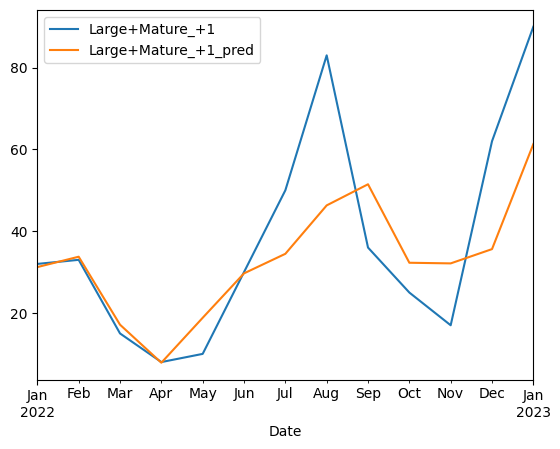

In [316]:
preds[(preds["Iter_n"] == 5) & (preds["FarmID"] == "GA331")][["Large+Mature_+1", "Large+Mature_+1_pred"]].plot()

In [309]:
scores[scores["rmse"] == scores["rmse"].min()]

,Iter_n,FarmID,Target,rmse,wmape,r2
1327,5,GA331,Large+Mature_+2,2.69,0.14,0.91


In [242]:
data.index[data["FarmID"] == "AG10"].tolist()
data.iloc[data.index[data["FarmID"] == "AG10"].tolist(), :]

,FarmID,year,month,Tiny+Small,Large+Mature,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,...,shortwave_radiation_sum,et0_fao_evapotranspiration,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm
0,AG10,1998,1,43.00,13.00,34.74,22.39,36.77,25.44,0.43,...,20.14,4.69,29.15,28.79,27.78,26.70,0.28,0.30,0.34,0.37
1,AG10,1998,2,28.00,28.00,35.19,24.32,39.12,28.38,1.86,...,20.27,4.71,30.21,29.86,28.97,27.35,0.35,0.33,0.32,0.36
2,AG10,1998,3,13.00,43.00,35.73,25.37,40.50,29.98,1.65,...,20.44,4.92,31.37,31.12,30.23,28.19,0.34,0.31,0.31,0.36
3,AG10,1998,4,11.50,38.00,33.10,24.90,39.12,29.94,4.07,...,17.88,4.01,29.08,29.18,29.36,28.79,0.41,0.37,0.30,0.35
4,AG10,1998,5,10.00,33.00,32.25,24.30,37.92,29.10,2.60,...,17.49,3.88,28.38,28.42,28.58,28.82,0.43,0.41,0.31,0.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,AG10,2023,3,5.00,17.00,34.22,24.03,38.95,28.22,2.51,...,20.19,4.76,29.87,29.87,29.78,28.56,0.38,0.31,0.30,0.36
303,AG10,2023,4,34.00,6.00,32.81,24.13,38.34,28.58,3.28,...,19.62,4.38,28.83,28.87,29.00,28.85,0.42,0.39,0.30,0.35
304,AG10,2023,5,47.00,13.00,31.70,23.88,37.49,28.69,4.65,...,17.65,3.82,27.96,28.07,28.42,28.78,0.44,0.43,0.31,0.35
305,AG10,2023,6,52.00,25.00,29.06,22.59,33.25,26.35,8.76,...,13.73,2.93,25.91,26.19,27.05,28.40,0.47,0.47,0.42,0.35


In [246]:
pd.DataFrame(np.array(data)[data.index[data["FarmID"] == "AG10"].tolist()])

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,AG10,1998,1,43.00,13.00,34.74,22.39,36.77,25.44,0.43,...,20.14,4.69,29.15,28.79,27.78,26.70,0.28,0.30,0.34,0.37
1,AG10,1998,2,28.00,28.00,35.19,24.32,39.12,28.38,1.86,...,20.27,4.71,30.21,29.86,28.97,27.35,0.35,0.33,0.32,0.36
2,AG10,1998,3,13.00,43.00,35.73,25.37,40.50,29.98,1.65,...,20.44,4.92,31.37,31.12,30.23,28.19,0.34,0.31,0.31,0.36
3,AG10,1998,4,11.50,38.00,33.10,24.90,39.12,29.94,4.07,...,17.88,4.01,29.08,29.18,29.36,28.79,0.41,0.37,0.30,0.35
4,AG10,1998,5,10.00,33.00,32.25,24.30,37.92,29.10,2.60,...,17.49,3.88,28.38,28.42,28.58,28.82,0.43,0.41,0.31,0.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,AG10,2023,3,5.00,17.00,34.22,24.03,38.95,28.22,2.51,...,20.19,4.76,29.87,29.87,29.78,28.56,0.38,0.31,0.30,0.36
303,AG10,2023,4,34.00,6.00,32.81,24.13,38.34,28.58,3.28,...,19.62,4.38,28.83,28.87,29.00,28.85,0.42,0.39,0.30,0.35
304,AG10,2023,5,47.00,13.00,31.70,23.88,37.49,28.69,4.65,...,17.65,3.82,27.96,28.07,28.42,28.78,0.44,0.43,0.31,0.35
305,AG10,2023,6,52.00,25.00,29.06,22.59,33.25,26.35,8.76,...,13.73,2.93,25.91,26.19,27.05,28.40,0.47,0.47,0.42,0.35


In [1]:
def split_category_data(data, n_splits, category_name):
    data_dict = {f"iter_{i}": {"train": pd.DataFrame(), "test": pd.DataFrame()} for i in range(1, n_splits+1)}

    # Tworzenie TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for category in data[category_name].unique():
        for i, (train_index, test_index) in enumerate(tscv.split(data[data[category_name] == category].index.values)):
            train_data = data[data[category_name] == category].iloc[train_index]
            test_data = data[data[category_name] == category].iloc[test_index]

            data_dict[f"iter_{i+1}"]["train"] = data_dict[f"iter_{i+1}"]["train"].append(train_data, ignore_index=True)
            data_dict[f"iter_{i+1}"]["test"] = data_dict[f"iter_{i+1}"]["test"].append(test_data, ignore_index=True)
    
    return data_dict

In [369]:
data = pd.read_csv("../Data/prepared_data.csv")

In [11]:
data["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in data.iterrows()]
data["Date"] = pd.to_datetime(data["Date"])
data.index = data["Date"]
data.drop(columns=["Date"], inplace=True)

In [18]:
data["FarmID"] = data["FarmID"].astype("category")

In [21]:
data

,FarmID,year,month,Tiny+Small,Large+Mature,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,...,shortwave_radiation_sum,et0_fao_evapotranspiration,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm
Date,,,,,,,,,,,,,,,,,,,,,
1998-01-01,AG10,1998,1,43.0,13.0,34.741935,22.393548,36.770968,25.441935,0.429032,...,20.136774,4.689677,29.146371,28.788575,27.784005,26.701613,0.283711,0.301133,0.337141,0.367218
1998-02-01,AG10,1998,2,28.0,28.0,35.189286,24.317857,39.117857,28.378571,1.857143,...,20.272143,4.714643,30.208780,29.864286,28.965923,27.353274,0.351561,0.334216,0.317765,0.362451
1998-03-01,AG10,1998,3,13.0,43.0,35.725806,25.367742,40.496774,29.983871,1.654839,...,20.438065,4.916774,31.365054,31.121774,30.227554,28.187097,0.338056,0.309485,0.305081,0.357526
1998-04-01,AG10,1998,4,11.5,38.0,33.100000,24.903333,39.120000,29.943333,4.073333,...,17.877667,4.014333,29.077639,29.184167,29.357361,28.793472,0.412431,0.368989,0.298226,0.352946
1998-05-01,AG10,1998,5,10.0,33.0,32.254839,24.303226,37.919355,29.096774,2.603226,...,17.486452,3.876129,28.380780,28.423656,28.578495,28.817876,0.429190,0.411262,0.310177,0.349663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01,MA413,2023,3,2.0,11.0,32.625806,23.593548,37.380645,27.251613,2.758065,...,19.784194,4.540323,28.529167,28.526478,28.419355,27.342876,0.390527,0.343621,0.305570,0.424620
2023-04-01,MA413,2023,4,2.0,3.0,32.833333,23.786667,37.903333,27.520000,2.563333,...,20.378667,4.632667,28.858889,28.759306,28.444028,27.731250,0.398275,0.348147,0.299015,0.413540
2023-05-01,MA413,2023,5,3.0,4.0,32.225806,24.061290,37.435484,28.312903,3.029032,...,18.983226,4.261290,28.559140,28.523656,28.383737,27.991801,0.416329,0.391871,0.301789,0.404790


In [22]:
data_dict = split_category_data(data, 5, "FarmID")

C:\Users\BC127735\AppData\Local\Temp\ipykernel_7248\801677198.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_dict[f"iter_{i+1}"]["train"] = data_dict[f"iter_{i+1}"]["train"].append(train_data, ignore_index=True)
C:\Users\BC127735\AppData\Local\Temp\ipykernel_7248\801677198.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_dict[f"iter_{i+1}"]["test"] = data_dict[f"iter_{i+1}"]["test"].append(test_data, ignore_index=True)


In [24]:
data_dict["iter_1"]["train"]

,FarmID,year,month,Tiny+Small,Large+Mature,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,...,shortwave_radiation_sum,et0_fao_evapotranspiration,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm
0,AG10,1998,1,43.0,13.0,34.741935,22.393548,36.770968,25.441935,0.429032,...,20.136774,4.689677,29.146371,28.788575,27.784005,26.701613,0.283711,0.301133,0.337141,0.367218
1,AG10,1998,2,28.0,28.0,35.189286,24.317857,39.117857,28.378571,1.857143,...,20.272143,4.714643,30.208780,29.864286,28.965923,27.353274,0.351561,0.334216,0.317765,0.362451
2,AG10,1998,3,13.0,43.0,35.725806,25.367742,40.496774,29.983871,1.654839,...,20.438065,4.916774,31.365054,31.121774,30.227554,28.187097,0.338056,0.309485,0.305081,0.357526
3,AG10,1998,4,11.5,38.0,33.100000,24.903333,39.120000,29.943333,4.073333,...,17.877667,4.014333,29.077639,29.184167,29.357361,28.793472,0.412431,0.368989,0.298226,0.352946
4,AG10,1998,5,10.0,33.0,32.254839,24.303226,37.919355,29.096774,2.603226,...,17.486452,3.876129,28.380780,28.423656,28.578495,28.817876,0.429190,0.411262,0.310177,0.349663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,MA413,2019,1,31.0,40.0,32.990323,23.083871,36.441935,26.583871,0.606452,...,18.905161,4.415484,28.586156,28.281989,27.384812,26.138038,0.303737,0.303587,0.347207,0.457535
1642,MA413,2019,2,35.0,49.0,33.360714,24.014286,37.185714,27.632143,2.021429,...,18.682143,4.474643,29.151786,28.944643,28.241071,26.779167,0.351728,0.313449,0.324515,0.442624
1643,MA413,2019,3,39.0,50.0,33.235484,24.006452,38.212903,27.941935,2.522581,...,20.485484,4.675806,28.924866,28.801882,28.440457,27.393414,0.397120,0.361007,0.312149,0.429652
1644,MA413,2019,4,10.0,33.0,31.400000,23.643333,37.220000,27.853333,4.326667,...,18.877333,4.071667,27.732917,27.741667,27.784722,27.682083,0.436268,0.431540,0.341674,0.420415


In [55]:
def train_test_model(model, train, test, steps_ahead):
    # Need to copy, otherwise weirdly is working on the parameters passed directly
    train = train.copy()
    test = test.copy()
    
    for i in range(1, steps_ahead+1):
        train[f"Tiny+Small_+{i}"] = train.groupby("FarmID")["Tiny+Small"].shift(-i)
        test[f"Tiny+Small_+{i}"] = test.groupby("FarmID")["Tiny+Small"].shift(-i)

        train[f"Large+Mature_+{i}"] = train.groupby("FarmID")["Large+Mature"].shift(-i)
        test[f"Large+Mature_+{i}"] = test.groupby("FarmID")["Large+Mature"].shift(-i)

    train = train.dropna()
    test = test.dropna()

    # One-hot encoding
    train = pd.get_dummies(train, columns=["FarmID"])
    test = pd.get_dummies(test, columns=["FarmID"])

    Xtr = train.drop(columns=list(train.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1).columns))
    ytr = train.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1)

    Xtest = test.drop(columns=list(test.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1).columns))
    ytest = test.filter(regex=('^(Tiny\+Small_\+\d|Large\+Mature_\+\d)'), axis=1)

    model.fit(Xtr, ytr)

    preds = model.predict(Xtest)

    scores = {"rmse": sqrt(mse(ytest, preds)), "wmape": wmape(ytest, preds), "r2": r2_score(ytest, preds)}

    return preds, scores

In [47]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

In [54]:
def wmape(y_true, y_pred):
    # Prevent from dividing by 0 like in MAPE
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [59]:
model = RandomForestRegressor()

# Fit the models on the training set.
preds, scores = train_test_model(model, data_dict["iter_1"]["train"], data_dict["iter_1"]["test"], 1)

In [60]:
scores

{'rmse': 27.285423994811286,
 'wmape': Tiny+Small_+1     0.47
 Large+Mature_+1   0.32
 dtype: float64,
 'r2': 0.5945755496852537}

In [356]:
# Set up parameter grid
param_grid = {  
    'bootstrap': [True, False],
    'max_depth': [100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [5],
    'n_estimators': [200, 400]
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

In [358]:
def random_search(param_grid, num_samples):
    random_combinations = []

    while len(random_combinations) < num_samples:
        random_combination = {}
        for param, values in param_grid.items():
            random_value = random.choice(values)
            random_combination[param] = random_value

        if random_combination not in random_combinations:
            random_combinations.append(random_combination)

    return random_combinations

In [365]:
# Set up parameter grid
param_grid = {  
    'bootstrap': [True, False],
    'max_depth': [None] + [i for i in range(10, 1010, 10)],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [5],
    'n_estimators': [200, 400]
}

In [366]:
num_samples = 10
random_combinations = random_search(param_grid, num_samples)

In [368]:
random_combinations

[{'bootstrap': True,
  'max_depth': 320,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 400},
 {'bootstrap': True,
  'max_depth': 90,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 200},
 {'bootstrap': False,
  'max_depth': 300,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 400},
 {'bootstrap': False,
  'max_depth': None,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 200},
 {'bootstrap': True,
  'max_depth': 190,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 200},
 {'bootstrap': True,
  'max_depth': 980,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 200},
 {'bootstrap': False,
  'max_depth': 850,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 400},
 {'

In [357]:
all_params

[{'bootstrap': True,
  'max_depth': 100,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 200},
 {'bootstrap': True,
  'max_depth': 100,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 400},
 {'bootstrap': True,
  'max_depth': 100,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 200},
 {'bootstrap': True,
  'max_depth': 100,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 400},
 {'bootstrap': True,
  'max_depth': None,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 200},
 {'bootstrap': True,
  'max_depth': None,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 400},
 {'bootstrap': True,
  'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 200},
 {'

In [81]:
len(all_params)

16

In [82]:
list_rmse = []

In [88]:
n_splits = 5
# Use cross validation to evaluate all parameters
for i, params in enumerate(all_params):
    print(f"Searching: {i+1}/{len(all_params)}")
    model = RandomForestRegressor(**params)
    temp_rmse = []
    for i in range(1, n_splits+1):
        preds, scores = train_test_model(model, data_dict[f"iter_{i}"]["train"], data_dict[f"iter_{i}"]["test"], 1)
        print(f"iter_{i}: rmse: {scores['rmse']}")
        temp_rmse.append(scores["rmse"])
    list_rmse.append(temp_rmse)

Searching: 1/16
iter_1: rmse: 27.194889981529517
iter_2: rmse: 27.36276620127314
iter_3: rmse: 22.267954456408674
iter_4: rmse: 23.324123159264616
iter_5: rmse: 20.14724619926489
Searching: 2/16
iter_1: rmse: 27.137768730212503
iter_2: rmse: 27.301192734041038
iter_3: rmse: 22.312432162321564
iter_4: rmse: 23.353275116978082
iter_5: rmse: 20.1354491713535
Searching: 3/16
iter_1: rmse: 29.815241342637606
iter_2: rmse: 31.177482511458553
iter_3: rmse: 23.020900523287448
iter_4: rmse: 23.089885925882935
iter_5: rmse: 20.462095705057337
Searching: 4/16
iter_1: rmse: 29.61883712684612
iter_2: rmse: 30.891818333617735
iter_3: rmse: 22.851002677207273
iter_4: rmse: 23.290017257158556
iter_5: rmse: 20.414003651494372
Searching: 5/16
iter_1: rmse: 27.40053997839348
iter_2: rmse: 27.30529788713445
iter_3: rmse: 22.34438108259126
iter_4: rmse: 23.375332552064595
iter_5: rmse: 20.056727377969114
Searching: 6/16
iter_1: rmse: 27.18899164647985
iter_2: rmse: 27.18607246275551
iter_3: rmse: 22.242031

In [107]:
[j[0] for j in [[np.mean(i), np.std(i)] for i in list_rmse[16:]]]

[24.059395999548165,
 24.048023582981337,
 25.513121201664777,
 25.41313580926481,
 24.096455775630577,
 23.9816024306078,
 25.541647396152506,
 25.518910191314237,
 32.47101815698374,
 32.41676633711233,
 25.21858064712079,
 25.208130164261977,
 32.44785011460425,
 32.45390515699137,
 25.20595725941699,
 25.10856334898822]

In [109]:
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse_mean'] = [j[0] for j in [[np.mean(i), np.std(i)] for i in list_rmse[16:]]]
tuning_results['rmse_std'] = [j[1] for j in [[np.mean(i), np.std(i)] for i in list_rmse[16:]]]
# Find the best parameters
best_params = all_params[np.argmin([j[0] for j in [[np.mean(i), np.std(i)] for i in list_rmse[16:]]])]
print(best_params)

{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}


In [110]:
tuning_results

,bootstrap,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,rmse_mean,rmse_std
0,True,100.00,auto,1,5,200,24.06,2.82
1,True,100.00,auto,1,5,400,24.05,2.79
2,True,100.00,sqrt,1,5,200,25.51,4.20
3,True,100.00,sqrt,1,5,400,25.41,4.09
4,True,NaN,auto,1,5,200,24.10,2.87
5,True,NaN,auto,1,5,400,23.98,2.82
6,True,NaN,sqrt,1,5,200,25.54,4.22
7,True,NaN,sqrt,1,5,400,25.52,4.16
8,False,100.00,auto,1,5,200,32.47,2.69
9,False,100.00,auto,1,5,400,32.42,2.69


In [111]:
model = RandomForestRegressor(**best_params)
for i in range(1, n_splits+1):
    preds, scores = train_test_model(model, data_dict[f"iter_{i}"]["train"], data_dict[f"iter_{i}"]["test"], 1)
    print(f"iter_{i}: {scores}")

iter_1: {'rmse': 27.250359190646133, 'wmape': Tiny+Small_+1     0.47
Large+Mature_+1   0.32
dtype: float64, 'r2': 0.5956834939111908}
iter_2: {'rmse': 27.182716154796108, 'wmape': Tiny+Small_+1     0.49
Large+Mature_+1   0.32
dtype: float64, 'r2': 0.6351801940115676}
iter_3: {'rmse': 22.176140562696837, 'wmape': Tiny+Small_+1     0.47
Large+Mature_+1   0.30
dtype: float64, 'r2': 0.6595852398692534}
iter_4: {'rmse': 23.29622086701054, 'wmape': Tiny+Small_+1     0.50
Large+Mature_+1   0.30
dtype: float64, 'r2': 0.596359190903703}
iter_5: {'rmse': 20.017359437999644, 'wmape': Tiny+Small_+1     0.55
Large+Mature_+1   0.32
dtype: float64, 'r2': 0.5547519833634289}
